# Distributing ML workload by Ray on Amazon SageMaker 

Ray is an open-source framework that provides a simple and flexible way to build and scale distributed applications. It is designed to enable efficient and high-performance distributed computing across a cluster of machines. Even on a single instance machine, Ray can help you distribute computations across available CPU cores, resulting in faster execution and better resource utilization. 

Amazon SageMaker supports multiple machine learning environments, including Amazon SageMaker Notebook Instances, which are computing focused instances running the Jupyter Notebook App. SageMaker manages creating the instance and related resources, then you can use Jupyter Notebooks in the notebook instance to run end to end ML workloads. In this blog, we will use a notebook instance to demonstrate Ray applications. 

## Distribute SageMake Training with Ray Train

Let's follow this [instruction](https://docs.aws.amazon.com/sagemaker/latest/dg/howitworks-create-ws.html) to create a ml.m5.4xlarge Notebook instance in Sagemaker, and click on **Open JupyterLab**

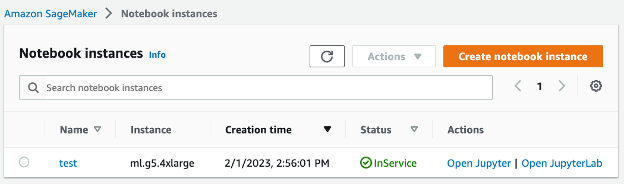


We'll begin by utilizing the example provided in SageMaker's [official](https://github.com/aws/amazon-sagemaker-examples/blob/main/frameworks/pytorch/get_started_mnist_train.ipynb) repository. Once you've cloned it to your notebook instance, initiate it using the `conda_pytorch_p39` kernel.

Firstly, let's examine the process employed by SageMaker for training a PyTorch model that classifies handwritten digits from the MNIST dataset. Within this example, you'll create a training script called `train.py`. This script constructs the neural network structure, loads the training and testing datasets, defines an optimizer, a loss function, and other necessary components. SageMaker encapsulates the training scripts by generating a SageMaker PyTorch estimator, which incorporates the framework and hardware specifications.

In [ ]:
from sagemaker.pytorch import PyTorch
est = PyTorch(
    entry_point="train.py", # training scripts
    source_dir="src_dir",  # directory of your training script
    role=role,
    framework_version="1.5.0",
    py_version="py3",
    instance_type=instance_type,
    instance_count=1,
    volume_size=250,
    output_path=output_path,
    hyperparameters={"batch-size": 128, "epochs": 1, "learning-rate": 1e-3, "log-interval": 100},
)

Next, you can initiate the SageMaker training process by invoking the fit method on the PyTorch estimator. This will train the model on the chosen **instance_type**.

For PyTorch training with Ray, we can utilize the TorchTrainer class, which serves as a trainer for data parallel PyTorch training. This trainer executes the `train_loop_per_worker` function on multiple Ray Actors. The `train_loop_per_worker` function accepts one argument called `train_loop_config`.

To enable this training script to work with Ray Train, we need to make the following modifications:
1. Add a `requirement.txt` file inside the `src_dir`, which includes **ray[air]** as a dependency.
2. In `src_dir/train.py`, we will utilize two preparation functions from the `ray.train.torch` library to prepare the dataloader and the neural network model for distributed training.

In [ ]:
from ray.train.torch import prepare_data_loader, prepare_model
def train(args):
    ...
    train_loader = DataLoader(
        MNIST(args.train, train=True), batch_size=args.batch_size, shuffle=True
    )
    test_loader = DataLoader(
        MNIST(args.test, train=False), batch_size=args.test_batch_size, shuffle=False
    )
    # Add data preparation
    train_loader = prepare_data_loader(train_loader)
    test_loader = prepare_data_loader(test_loader)

    net = Net().to(device)
    # Add model preparation 
    net = prepare_model(net)

3. Instead of directly invoking the`train()` function, we utilize the `TorchTrainer` class to create a trainer based on the `train()` function. We then call `trainer.fit()` to initiate the training process. 

In [ ]:
if __name__ == "__main__":
    args = parse_args()
    #Skip the original train() function call
    #train(args)
    from ray.train.torch import TorchTrainer
    from ray.air.config import ScalingConfig
    trainer = TorchTrainer(
        train_loop_per_worker=train,
        train_loop_config=args,
        scaling_config=ScalingConfig(num_workers=1, use_gpu=False),
    )
    trainer.fit()

Now, we can return to the Jupyter notebook and commence the training by using the `fit()` method from the estimator.

Here is the output when using **'local'** as the instance type, where the training runs on the same instance as the Jupyter notebook.
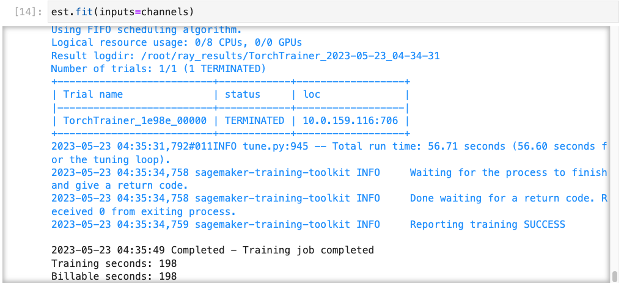

Alternatively, you can specify an instance type such as **ml.m5.2xlarge** to submit the job and execute it in SageMaker training. This allows you to monitor the progress of the training job within the SageMaker environment.

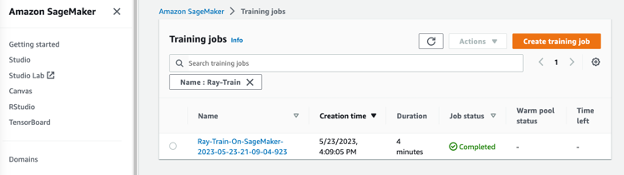

## Parallel Hyperparameter tuning with Ray Tune

After exploring the process of running a training job on Amazon SageMaker, let's dive into a more intriguing example: running Ray Tune. Ray Tune is a powerful and versatile library that facilitates hyperparameter tuning for ML models, and it simplifies the process of experimenting with various combinations of hyperparameters,and accelerate the search for optimal hyperparameters by distributed computing. 

To convert the training script for Ray Tune, follow these steps:

1. Create another copy of the training script file and name it `tune.py`. Since Ray Tune expects parameters in the form of a dictionary, we need to modify the `train()` function as follows.

In [ ]:
from argparse import Namespace
from ray.air import session
from ray.air.checkpoint import Checkpoint
def train(config):
    # convert the config from dict type to Namespace
    args = Namespace(**config)
    # Begin of the original train.py code
    use_cuda = args.num_gpus > 0
    ...
    save_model(net, args.model_dir)
    # End of the original train.py code

    # Add ‘loss’ as the report session
    checkpoint = Checkpoint.from_directory(args.model_dir)
    session.report({"loss": loss.item()}, checkpoint=checkpoint)

    return

2. Modify the main function to create a tuner. In this example, we use grid search to tune **beta_1** and **beta_2** and use 1 cpu for each trial. 


In [ ]:
if __name__ == "__main__":
    args = parse_args()
    #Skip the original train() function call
    #train(args)
    from ray import tune
    config = vars(args)
    config["beta_1"] = tune.grid_search([0.75, 0.8, 0.85, 0.9])
    config["beta_2"] = tune.grid_search([0.99, 0.98, 0.97, 0.96])
    
    resources_per_trial = {"cpu": 1}
    tuner = tune.Tuner(
        tune.with_resources(train, resources=resources_per_trial),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            num_samples=1
        ),
        param_space=config
    )
    tuner.fit()


Similar to Ray Train, we initiate the tuning process by using `est.fit()`. You can observe that all 16 CPUs on the **ml.m5.4xlarge** instance are utilized to execute 16 trials in parallel, which can be monitored through CloudWatch.
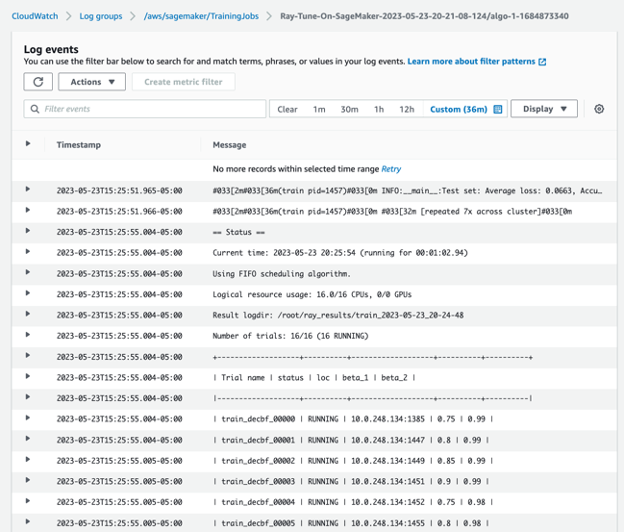

## Submit Anyscale jobs from Amazon SageMaker
Using Ray on Amazon SageMaker is truly remarkable, as it allows users to experience Ray for efficient distributed computing. However, it does come with a limitation of being restricted to a single instance, limiting its potential scalability. Fortunately, with the introduction of Anyscale, we can now fully unleash the power of Ray by running it across multiple cluster instances.

To create an Anyscale job, you can reuse the training script file `train.py` and modify the arguments accordingly. Additionally, you'll need to create a `sagemaker_job.yaml` file to specify the cluster type (including head and worker node types) and the cluster's software environment (including the base Docker image and any necessary pip/conda dependencies, etc). Using the Anyscale CLI, which can be installed via `pip install anyscale`, you can submit the job to Anyscale after authenticating.
Here are the steps:

1. Authenticate with Anyscale:
```Anyscale login```  
2. Submit the job using the specified YAML file:  
```anyscale job submit -f sagemeker_job.yaml```  

Now you can monitor the job in Anyscale console, which provides a comprehensive view of tis progress and status
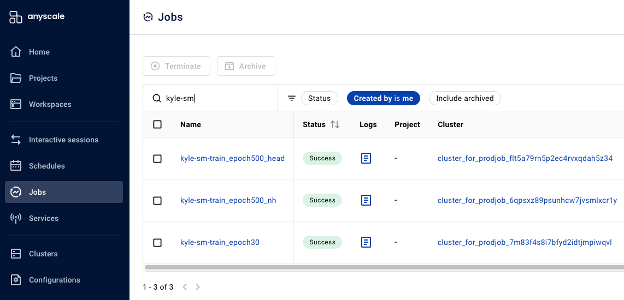

## Summary
By utlizating SageMaker's managed infrastructure, you gain access to Ray's parallel processing, fault torlerane, and auto scaling capabilities. This combination offers numerous advantages, such as enhanced scalability, increased GPU utilization rate, and improved productivity for your ML workflows, resulting in cost savings. 

Feel free to explore Ray on SageMaker to experience its capabilities firsthand. Once you're ready, you can take the next step and unleash the full power of Ray on Anyscale. 